# Production Technology

The dataset contains `N = 441` firms observed over `T = 12` years, 1967-1978. There variables are: 
* `lcap`: Log of capital stock, $k_{it}$ 
* `lemp`: log of employment, $\ell_{it}$ 
* `ldsa`: log of deflated sales, $y_{it}$
* `year`: the calendar year of the observation, `year` $ = 1967, ..., 1978$, 
* `firmid`: anonymized indicator variable for the firm, $i = 1, ..., N$, with $N=441$. 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from scipy.stats import chi2
import scipy.stats
from tabulate import tabulate
from numpy import linalg as la
import LinearDynamic_ante as lm
#import LinearModelsWeek3 as lm
%load_ext autoreload
%autoreload 2

In [2]:
dat = pd.read_csv('firms.csv')

In [3]:
dat.sample(5)

,firmid,year,lcap,lemp,ldsa
1813,152,1968,1.342024,1.480875,1.484999
276,24,1967,0.044289,0.247113,0.276631
1393,117,1968,1.442513,1.790217,1.802479
339,29,1970,-1.213090,-1.016690,-1.315920
1096,92,1971,-1.239200,-1.317150,-1.228270


In [4]:
dat.year.unique()

array([1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978], dtype=int64)

# Descriptives

In [5]:
dat.describe()

,firmid,year,lcap,lemp,ldsa
count,5292.000000,5292.000000,5.292000e+03,5.292000e+03,5.292000e+03
mean,221.000000,1972.500000,-2.379856e-08,-3.248299e-08,-4.440666e-10
std,127.317437,3.452379,1.323176e+00,1.187237e+00,1.234902e+00
min,1.000000,1967.000000,-4.033590e+00,-3.382780e+00,-3.554090e+00
25%,111.000000,1969.750000,-9.251980e-01,-8.001460e-01,-9.190837e-01
50%,221.000000,1972.500000,-1.083100e-01,-1.147060e-01,-1.105555e-01
75%,331.000000,1975.250000,9.307292e-01,7.973080e-01,8.622255e-01
max,441.000000,1978.000000,4.103687e+00,3.371332e+00,3.913391e+00


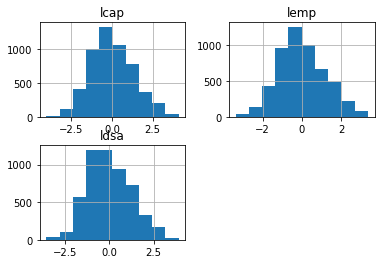

In [6]:
dat[['lcap','lemp','ldsa']].hist(); 

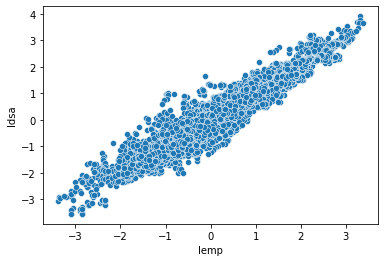

In [7]:
sns.scatterplot(x='lemp', y='ldsa', data=dat); 

# Converting data to numpy format 

In [8]:
dat.ldsa.values.shape

(5292,)

In [9]:
N = dat.firmid.unique().size
T = dat.year.unique().size
assert dat.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

Data has N=441 and T=12


Extract data from `pandas` to `numpy` arrays. 

In [10]:
y = dat.ldsa.values.reshape((N*T,1))

ones = np.ones((N*T,1))
l = dat.lemp.values.reshape((N*T,1))
k = dat.lcap.values.reshape((N*T,1))
x = np.hstack([ones, l, k])

In [11]:
label_y = 'Log deflated sales'
label_x = [
    'Constant', 
    'Log employment', 
    'Log capital stock'
]

In [12]:
print(N)

441


# OLS

In [13]:
ols_result = lm.estimate(y, x, T=T, robust_se=True, N=N)

lm.print_table(
    (label_y, label_x), ols_result, title="Pooled OLS", floatfmt='.4f')

Pooled OLS
Dependent variable: Log deflated sales

                     Beta      Se    t-values    p_val
-----------------  ------  ------  ----------  -------
Constant           0.0000  0.0161      0.0000   0.5000
Log employment     0.6778  0.0360     18.8447   0.0000
Log capital stock  0.3028  0.0318      9.5317   0.0000
R² = 0.914
σ² = 0.130


# FE

In [14]:
# Check rank of demeaned matrix, and return its eigenvalues.
def check_rank(x):
    print(f'Rank of demeaned x: {la.matrix_rank(x)}')
    lambdas, V = la.eig(x.T@x)
    np.set_printoptions(suppress=True)  # This is just to print nicely.
    print(f'Eigenvalues of within-transformed x: {lambdas.round(decimals=0)}')

In [15]:
def demeaning_matrix(T):
    Q_T = np.eye(T) - np.tile(1/T, (T, T))
    return Q_T

In [16]:
Q_T = demeaning_matrix(T)

y_demean = lm.perm(Q_T, y)
x_demean = lm.perm(Q_T, x)

In [17]:
check_rank(x_demean)

Rank of demeaned x: 2
Eigenvalues of within-transformed x: [  0.  61. 238.]


In [18]:
x_demean_full = x_demean[:, 1:]
print(x_demean_full)
label_x_fe = label_x[1:]
print(label_x_fe)

[[0.02551608 0.13576148]
 [0.05351308 0.09446318]
 [0.05442008 0.02107538]
 ...
 [0.47838308 0.32242483]
 [0.58132608 0.49459083]
 [0.62999708 0.67698383]]
['Log employment', 'Log capital stock']


In [19]:
fe_result = lm.estimate(
    y_demean, x_demean_full, transform='fe', T=T, robust_se=True, N=N
)

lm.print_table(
    (label_y, label_x_fe), 
    fe_result, title='FE regression', floatfmt='.4f'
)

FE regression
Dependent variable: Log deflated sales

                     Beta      Se    t-values    p_val
-----------------  ------  ------  ----------  -------
Log employment     0.6964  0.0418     16.6568   0.0000
Log capital stock  0.1427  0.0282      5.0664   0.0000
R² = 0.492
σ² = 0.017


# FD

In [20]:
def fd_matrix(T):
    D_T = np.eye(T) - np.eye(T, k=-1)
    D_T = D_T[1:]
    return D_T

In [21]:
# Transform the data.
D_T = fd_matrix(T)
y_diff = lm.perm(D_T, y)
x_diff = lm.perm(D_T, x)

# Again, check rank condition.
check_rank(x_diff)
print(x_diff)

# Remember to remove linear dependent columns
x_diff_full = x_diff[:, 1:]
print(x_diff_full)

Rank of demeaned x: 2
Eigenvalues of within-transformed x: [38. 52.  0.]
[[ 0.         0.027997  -0.0412983]
 [ 0.         0.000907  -0.0733878]
 [ 0.        -0.023856  -0.0455976]
 ...
 [ 0.         0.18107    0.114647 ]
 [ 0.         0.102943   0.172166 ]
 [ 0.         0.048671   0.182393 ]]
[[ 0.027997  -0.0412983]
 [ 0.000907  -0.0733878]
 [-0.023856  -0.0455976]
 ...
 [ 0.18107    0.114647 ]
 [ 0.102943   0.172166 ]
 [ 0.048671   0.182393 ]]


In [22]:
fd_result = lm.estimate(y_diff, x_diff_full, T=T-1, robust_se=True, N=N)

lm.print_table(
    (label_y, label_x_fe), 
    fd_result, title='FD regression', floatfmt='.4f'
)

FD regression
Dependent variable: Log deflated sales

                     Beta      Se    t-values    p_val
-----------------  ------  ------  ----------  -------
Log employment     0.5462  0.0277     19.7080   0.0000
Log capital stock  0.0645  0.0224      2.8836   0.0021
R² = 0.174
σ² = 0.014


# RE

In [23]:
#Create P
P=np.tile(1/T, (T)).reshape(1,-1)
print(P.shape)

(1, 12)


In [24]:
#Mean x and y using perm and P
y_re = lm.perm(P, y)
x_re = lm.perm(P, x)

In [25]:
#regress y_mean on x_mean, N rows not NT
be_result = lm.estimate(y_re, x_re, T=T, robust_se=True, N=N)

lm.print_table(
    (label_y, label_x), ols_result, title="BE", floatfmt='.4f')

BE
Dependent variable: Log deflated sales

                     Beta      Se    t-values    p_val
-----------------  ------  ------  ----------  -------
Constant           0.0000  0.0161      0.0000   0.5000
Log employment     0.6778  0.0360     18.8447   0.0000
Log capital stock  0.3028  0.0318      9.5317   0.0000
R² = 0.914
σ² = 0.130


In [26]:
sigma2_u = fe_result.get('sigma2')
sigma2_w = be_result.get('sigma2')
sigma2_c = sigma2_w - (1/T)*sigma2_u

In [27]:
_lambda = 1 - np.sqrt(sigma2_u / (sigma2_u + T*sigma2_c))  
print(_lambda)

0.8871848347640463


In [28]:
C_T= np.eye(T)-_lambda*P 

In [29]:
y_qmean = lm.perm(C_T, y)
x_qmean = lm.perm(C_T, x)

In [30]:
re_result = lm.estimate(y_qmean, x_qmean, T=T, robust_se=True, N=N)

lm.print_table(
    (label_y, label_x), re_result, _lambda=_lambda, title="RE", floatfmt='.4f')

RE
Dependent variable: Log deflated sales

                     Beta      Se    t-values    p_val
-----------------  ------  ------  ----------  -------
Constant           0.0000  0.0169      0.0000   0.5000
Log employment     0.7235  0.0330     21.9034   0.0000
Log capital stock  0.1852  0.0249      7.4265   0.0000
R² = 0.649
σ² = 0.018
λ = 0.887


# Hausman test

In [31]:
# Follow the steps in the question
hat_diff = fe_result.get('b_hat')-re_result.get('b_hat')[1:]
cov_diff = fe_result.get('cov') - re_result.get('cov')[1:,1:]
H = hat_diff.T @ la.inv(cov_diff) @ hat_diff

# Antal frihedsgrader er rank på cov_diff

# This calculates the p-value of the Hausman test.
p_val = chi2.sf(H.item(), 2)

In [32]:
f = re_result.get('b_hat')[1:]
print(f)
d = re_result.get('b_hat')[:]
print(d)

[[0.72345074]
 [0.1851568 ]]
[[0.00000003]
 [0.72345074]
 [0.1851568 ]]


In [33]:
f = re_result.get('cov')[1:,1:]
print(f)

[[ 0.00109092 -0.00065354]
 [-0.00065354  0.00062161]]


In [34]:
# This code takes the results that you have made, and prints a nice looking table.
def print_h_test(fe_result, re_result, hat_diff, p_val):
    table = []
    for i in range(len(hat_diff)):
        row = [
            fe_result['b_hat'][i], re_result['b_hat'][1:][i], hat_diff[i]
        ]
        table.append(row)

    print(tabulate(
        table, headers=['b_fe', 'b_re', 'b_diff'], floatfmt='.4f'
        ))
    print(f'The Hausman test statistic is: {H.item():.2f}, with p-value: {p_val:.2f}.')
print_h_test(fe_result, re_result, hat_diff, p_val)

  b_fe    b_re    b_diff
------  ------  --------
0.6964  0.7235   -0.0271
0.1427  0.1852   -0.0425
The Hausman test statistic is: 11.18, with p-value: 0.00.


# Testing for CRS, $\beta_{k} + \beta_{l} = 1$ 

Vi skal teste for <br> 
$H_0 : R\beta = r$  <br>
$R=[1, 1]$, og $r=1$ 

In [35]:
R = np.array([1,1]).reshape(1,-1)
print(R.shape)
print(R)
r=1
print(r)

(1, 2)
[[1 1]]
1


# CRS-test POLS

In [36]:
b_hat = ols_result.get('b_hat')[1:]
a_var = ols_result.get('cov')[1:,1:]
print(b_hat)

W = (R@b_hat -r).T @ la.inv(R@ a_var @ R.T) @ (R@ b_hat -r)

# This calculates the p-value of the Wald test.
p_val = chi2.sf(W.item(), 1)
print(f'The Wald test statistic is: {W.item():.2f}, with p-value: {p_val:.2f}.')

[[0.67782694]
 [0.30275923]]
The Wald test statistic is: 2.56, with p-value: 0.11.


In [37]:
0.67782694+0.0101+0.30275923+0.0090

0.99968617

In [38]:
0.67782694+0.30275923

0.98058617

# CRS-test FE

In [39]:
b_hat = fe_result.get('b_hat')
a_var = fe_result.get('cov')
print(b_hat)

W = (R@b_hat -r).T @ la.inv(R@ a_var @ R.T) @ (R@ b_hat -r)
print(W)

# This calculates the p-value of the Wald test.
p_val = chi2.sf(W.item(), 1)
print(f'The Wald test statistic is: {W.item():.2f}, with p-value: {p_val:.2f}.')

[[0.69638705]
 [0.14266302]]
[[20.12845884]]
The Wald test statistic is: 20.13, with p-value: 0.00.


# CRS-test FD

In [40]:
b_hat = fd_result.get('b_hat')
a_var = fd_result.get('cov')
print(b_hat)

W = (R@b_hat -r).T @ la.inv(R@ a_var @ R.T) @ (R@ b_hat -r)
print(W)

# This calculates the p-value of the Wald test.
p_val = chi2.sf(W.item(), 1)
print(f'The Wald test statistic is: {W.item():.2f}, with p-value: {p_val:.2f}.')

[[0.54615461]
 [0.06448113]]
[[164.42713216]]
The Wald test statistic is: 164.43, with p-value: 0.00.


# CRS-test RE

In [41]:
b_hat = re_result.get('b_hat')[1:]
a_var = re_result.get('cov')[1:,1:]
print(b_hat)

W = (R@b_hat -r).T @ la.inv(R@ a_var @ R.T) @ (R@ b_hat -r)
print(W)

# This calculates the p-value of the Wald test.
p_val = chi2.sf(W.item(), 1)
print(f'The Wald test statistic is: {W.item():.2f}, with p-value: {p_val:.2f}.')

[[0.72345074]
 [0.1851568 ]]
[[20.60052376]]
The Wald test statistic is: 20.60, with p-value: 0.00.


# Skema med de samlede koefficienter

In [42]:
def print_test(ols_result, fe_result, fd_result, re_result):
    table = []
    for i, name in enumerate(label_x_fe):
        row = [
            name,
            ols_result['b_hat'][1:][i], fe_result['b_hat'][i], fd_result['b_hat'][i], re_result['b_hat'][1:][i]
        ]
        table.append(row)
    print(tabulate(
        table, headers=['b_ols','b_fe', 'b_fd', 'b_re'], floatfmt='.4f'
        ))

print_test(ols_result, fe_result, fd_result, re_result)



                     b_ols    b_fe    b_fd    b_re
-----------------  -------  ------  ------  ------
Log employment      0.6778  0.6964  0.5462  0.7235
Log capital stock   0.3028  0.1427  0.0645  0.1852


In [43]:
ar1_res=pd.DataFrame([ols_result['b_hat'][1:].flatten(), fe_result['b_hat'].flatten(), fd_result['b_hat'].flatten(), re_result['b_hat'][1:].flatten()], 
             index=['b_ols','b_fe', 'b_fd', 'b_re'], columns=label_x_fe).T

ar1_res.round(3)

,b_ols,b_fe,b_fd,b_re
Log employment,0.678,0.696,0.546,0.723
Log capital stock,0.303,0.143,0.064,0.185


In [44]:
# Make latex table
(ar1_res.round(3)).style.to_latex()

'\\begin{tabular}{lrrrr}\n{} & {b_ols} & {b_fe} & {b_fd} & {b_re} \\\\\nLog employment & 0.678000 & 0.696000 & 0.546000 & 0.723000 \\\\\nLog capital stock & 0.303000 & 0.143000 & 0.064000 & 0.185000 \\\\\n\\end{tabular}\n'